<a href="https://colab.research.google.com/github/rockdrigoma/extraccionGastosBanco/blob/main/GastosCalc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXTRACTOR DE GASTOS DE ESTADO DE CUENTA BBVA

Este es un script que permite extraer los renglones de gastos, pagos, devoluciones y meses sin intereses de un estado de cuenta de BBVA Mexico.

También intenta etiquetar algunos conceptos utilizando un modelo de IA y crear una gráfica para visualizar en qué rubros se ha estado gastando más.

Recuerda colocar los estados de cuenta en formato PDF en el mismo directorio en el que este script se encuentra. El script leerá automáticamente todo lo que tenga una extensión .PDF y se encuentre al mismo nivel que este script.

## 1. Primero instalamos los paquetes necesarios

In [ ]:
# @title
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext pandas

## 2. Establecemos las opciones de visualización

In [ ]:
# @title
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.width = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_info_columns = 100
pd.options.display.precision = 5
pd.options.display.float_format = '{:.1f}'.format

In [ ]:
# @title
pd.set_option('display.expand_frame_repr', False)

## 3. Definimos las reglas de extracción como expresiones regulares. Estas pueden requerir actualización, modificación o borrado dependiendo si BBVA cambia su formato de estado de cuenta.

In [ ]:
# @title
import re
import os
import pdftotext

gastos = []
devoluciones = []
mensualidades = []
meses_sin_intereses = []
pago_tarjeta = []

not_matching = []
trans_pat_1 = (
        r'(?P<date1>\d+/\d+/\d+)\s*'
        r'(?P<date2>\d+/\d+/\d+)\s*'
        r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
        r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
        r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
        r'\$\s*'
        r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_2 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_3 = (
    r'(?P<date1>\d+/\d+/\d+)\s*'
    r'(?P<date2>\d+/\d+/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_4 = (
    r'(?P<date1>\d+/\d+/\d+)\s*'
    r'(?P<date2>\d+/\d+/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_5 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_6 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_7 = (
    r'(?P<date1>\d+\/\d+\/\d+)\s*'
    r'(?P<date2>\d+\/\d+\/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)


trans_pat_7_1 = (
    r'(?P<date1>\d+\/\d+\/\d+)\s*'
    r'(?P<date2>\d+\/\d+\/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<REFERENCIA>[\*]{6}[\d]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_1_2 = (
        r'(?P<date1>\d+/\d+/\d+)\s*'
        r'(?P<date2>\d+/\d+/\d+)\s*'
        r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
        r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
        r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
        r'\$\s*'
        r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_2_2 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_3_2 = (
    r'(?P<date1>\d+/\d+/\d+)\s*'
    r'(?P<date2>\d+/\d+/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<RFC>[A-Z]{3,4}[ ]?[0-9]{6}[A-Z0-9]{3})\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_5_2 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'(?P<REFERENCIA>\*{6}[0-9]{4})\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_6_2 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_6_3 = (
    r'(?P<date1>\d+-\d+-\d+)\s*'
    r'(?P<date2>///[0-9]{2})\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4})'
)

trans_pat_7_2 = (
    r'(?P<date1>\d+/\d+/\d+)\s*'
    r'(?P<date2>\d+/\d+/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'\$\s*'
    r'(?P<CANTIDAD>[0-9,]{1,7}\.[0-9]{1,4}-)'
)

trans_pat_8 = (
    r'(?P<date1>\d+/\d+/\d+)\s*'
    r'(?P<description>[-\.\/\w0-9\* ]+?)\s*'
    r'\$\s*(?P<TOTAL>[0-9,]{1,7}\.[0-9]{1,4})\s*'
    r'\$\s*(?P<PARCIAL>[0-9,]{1,7}\.[0-9]{1,4})\s*'
    r'(?P<MENSUALIDAD>[0-9]{2} de [0-9]{2})\s*'
    r'\$\s*'
    r'(?P<RESTANTE>[0-9,]{1,7}\.[0-9]{1,4})'
)



## 4. Comenzamos la lectura de PDFs. Si se quiere extraer sólo de un PDF, se modifica el nombre a algo más particular como 'estadoCuentaSeptiembre2024'. Si se quiere extraer lo de varios PDFs se modifica como algo más general que tengan en común los nombres de todos los PDFs como 'estadoCuenta'.

In [ ]:
# @title
nombre_archivos = '.pdf' #cambia el contenido de este valor de acuerdo al nombre de tus archivos
count = 0
for i in os.listdir():
  if nombre_archivos in i:
    print(i)
    with open(f"/content/{i}", "rb") as file:
      pdf = pdftotext.PDF(file, physical=True)
      for i, page in enumerate(pdf):
        first_page = pdf[i]
        lines = first_page.split("\n")
        for line in lines:
          count += 1
          line = line.strip()
          line = line.replace(',', '')
          match_1 = re.search(pattern=trans_pat_1, string=line)
          match_2 = re.search(pattern=trans_pat_2, string=line)
          match_3 = re.search(pattern=trans_pat_3, string=line)
          match_4 = re.search(pattern=trans_pat_4, string=line)
          match_5 = re.search(pattern=trans_pat_5, string=line)
          match_6 = re.search(pattern=trans_pat_6, string=line)
          match_7_1 = re.search(pattern=trans_pat_7_1, string=line)
          match_7 = re.search(pattern=trans_pat_7, string=line)
          match_1_2 = re.search(pattern=trans_pat_1_2, string=line)
          match_2_2 = re.search(pattern=trans_pat_2_2, string=line)
          match_3_2 = re.search(pattern=trans_pat_3_2, string=line)
          match_5_2 = re.search(pattern=trans_pat_5_2, string=line)
          match_6_2 = re.search(pattern=trans_pat_6_2, string=line)
          match_6_3 = re.search(pattern=trans_pat_6_3, string=line)
          match_7_2 = re.search(pattern=trans_pat_7_2, string=line)
          match_8 = re.search(pattern=trans_pat_8, string=line)
          if 'S/I' in line or 'MSI' in line:
            if match_7_1:
              mensualidades.append(match_7_1.groupdict())
            elif match_7:
              mensualidades.append(match_7.groupdict())
            elif match_6_3:
              mensualidades.append(match_6_3.groupdict())
            else:
              not_matching.append(line)
          elif 'BMOVIL.PAGO TDC' in line:
            if match_1:
              pago_tarjeta.append(match_1.groupdict())
            elif match_2:
              pago_tarjeta.append(match_2.groupdict())
            elif match_1:
              pago_tarjeta.append(match_1.groupdict())
            elif match_3:
              pago_tarjeta.append(match_3.groupdict())
            elif match_5:
              pago_tarjeta.append(match_5.groupdict())
            elif match_6:
              pago_tarjeta.append(match_6.groupdict())
            elif match_7:
              pago_tarjeta.append(match_7.groupdict())
            else:
              not_matching.append(line)
          elif match_4:
            devoluciones.append(match_4.groupdict())
          elif match_1_2:
            devoluciones.append(match_1_2.groupdict())
          elif match_2_2:
            devoluciones.append(match_2_2.groupdict())
          elif match_3_2:
            devoluciones.append(match_3_2.groupdict())
          elif match_5_2:
            devoluciones.append(match_5_2.groupdict())
          elif match_6_2:
            devoluciones.append(match_6_2.groupdict())
          elif match_7_2:
            devoluciones.append(match_7_2.groupdict())
          elif match_2:
            gastos.append(match_2.groupdict())
          elif match_1:
            gastos.append(match_1.groupdict())
          elif match_3:
            gastos.append(match_3.groupdict())
          elif match_5:
            gastos.append(match_5.groupdict())
          elif match_6:
            gastos.append(match_6.groupdict())
          elif match_7_1:
            gastos.append(match_7_1.groupdict())
          elif match_7:
            gastos.append(match_7.groupdict())
          elif match_8:
            meses_sin_intereses.append(match_8.groupdict())
          else:
            not_matching.append(line)

# Este es el número total de renglones revisados

In [ ]:
# @title
count

# Total de gastos encontrados

In [ ]:
# @title
len(gastos)

# Total de devoluciones

In [ ]:
# @title
len(devoluciones)

# Total de promociones de meses sin intereses iniciadas este mes

In [ ]:
# @title
len(mensualidades)

# Total de renglones que fueron ignorados por las reglas

In [ ]:
# @title
len(not_matching)

# Total de pagos a capital hechos

In [ ]:
# @title
len(pago_tarjeta)

# Total de promociones que están a meses sin intereses

In [ ]:
# @title
len(meses_sin_intereses)

# Total de renglones categorizados, si no coincide con el count de arriba, significa que el script fallo en leer algunos renglones

In [ ]:
# @title
len(gastos)+len(devoluciones)+len(mensualidades)+len(not_matching)+len(pago_tarjeta)+len(meses_sin_intereses)

# 5. Comenzamos la carga de cada rubro:
* Gastos: Lo que pagaste con tu tarjeta
* Devoluciones: Cosas que pagaste pero que devolviste y por lo tanto fueron devueltas a tu tarjeta
* Mensualidades: Mensualidades parciales a pagar este mes
* Meses sin intereses: Lista de todos tus meses sin intereses
* Pagos a tarjeta: Pagos que hiciste a tu tarjeta desde la app movil

In [ ]:
# @title
import pandas as pd
gastos = pd.DataFrame(gastos)
devoluciones = pd.DataFrame(devoluciones)
mensualidades = pd.DataFrame(mensualidades)
meses_sin_intereses = pd.DataFrame(meses_sin_intereses)
pago_tarjeta = pd.DataFrame(pago_tarjeta)

In [ ]:
# @title
gastos['CANTIDAD'] = gastos['CANTIDAD'].astype(float)
gastos['date1'] = pd.to_datetime(gastos['date1'], format='mixed')
gastos['REFERENCIA'] = gastos['REFERENCIA'].fillna('NO_REF')
gastos['RFC'] = gastos['RFC'].fillna('NO_RFC')
if len(devoluciones) > 0:
  devoluciones['CANTIDAD'] = devoluciones['CANTIDAD'].str.replace('-', '')
  devoluciones['CANTIDAD'] = devoluciones['CANTIDAD'].astype(float)
  devoluciones['date1'] = pd.to_datetime(devoluciones['date1'], format='mixed')
  devoluciones['REFERENCIA'] = devoluciones['REFERENCIA'].fillna('NO_REF')
  devoluciones['RFC'] = devoluciones['RFC'].fillna('NO_RFC')
meses_sin_intereses['TOTAL'] = meses_sin_intereses['TOTAL'].astype(float)
meses_sin_intereses['PARCIAL'] = meses_sin_intereses['PARCIAL'].astype(float)
meses_sin_intereses['RESTANTE'] = meses_sin_intereses['RESTANTE'].astype(float)
mensualidades['CANTIDAD'] = mensualidades['CANTIDAD'].astype(float)
pago_tarjeta['CANTIDAD'] = pago_tarjeta['CANTIDAD'].astype(float)

# Total restante que te queda por pagar de todos tus meses sin intereses, no todo es a pagar este mes. Si colocaste más de un estado de cuenta, esta cifra no te servirá

In [ ]:
# @title
meses_sin_intereses['RESTANTE'].sum()

# Total de compras que realizaste este mes

In [ ]:
# @title
gastos['CANTIDAD'].sum()

# Total de pagos devueltos a tarjeta por devoluciones

In [ ]:
# @title
if len(devoluciones) > 0:
  print(devoluciones['CANTIDAD'].sum())
else:
  print('No hay devoluciones')

# Total de todas las mensualidades a pagar este mes, si colocaste más de un estado de cuenta, esta cifra no te servirá

In [ ]:
# @title
meses_sin_intereses['PARCIAL'].sum()

# Total de pagos a tarjeta realizados, usualmente es lo que pagaste para saldar tu tarjeta en el periodo pasado

In [ ]:
# @title
pago_tarjeta['CANTIDAD'].sum()

# Lista de gastos del período de mayor a menor agrupados por RFC y descripción

In [ ]:
# @title
gastos.groupby(['RFC', 'description'])['CANTIDAD'].sum().sort_values(ascending=False)

# Pagos realizados a capital

In [ ]:
# @title
pago_tarjeta

# 6. Intentando categorizar cada gasto utilizando la descripción o concepto del gasto

Aquí se utiliza un modelo de clasificación para intentar predecir el rubro de cada gasto basado en la descripción, RFC y referencia.






In [ ]:
# @title
!wget https://raw.githubusercontent.com/rockdrigoma/extraccionGastosBanco/main/text_classification_model.joblib

In [ ]:
# @title
from joblib import load

model = load('text_classification_model.joblib')
gastos['RUBRO'] = model.predict(gastos['description'])

# 7. Graficando los rubros por gasto mensual

Visualizando gastos por Rubro

<Axes: >

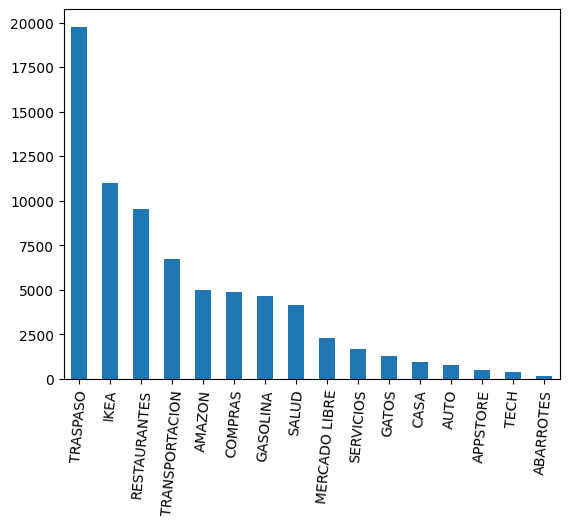

In [33]:
# @title
x_ticks = []
for l in gastos.groupby(['RUBRO'])['CANTIDAD'].sum().sort_values(ascending=False).reset_index()['RUBRO'].to_list():
  x_ticks.append(gastos.loc[gastos['RUBRO'] == l, 'RUBRO'].to_list()[0])

to_plot = gastos.groupby(['RUBRO'])['CANTIDAD'].sum().sort_values(ascending=False)
to_plot.index = x_ticks
to_plot.plot(kind='bar', rot=85)

# 8. Gráfica de pastel de los mismos rubros

<Axes: ylabel='CANTIDAD'>

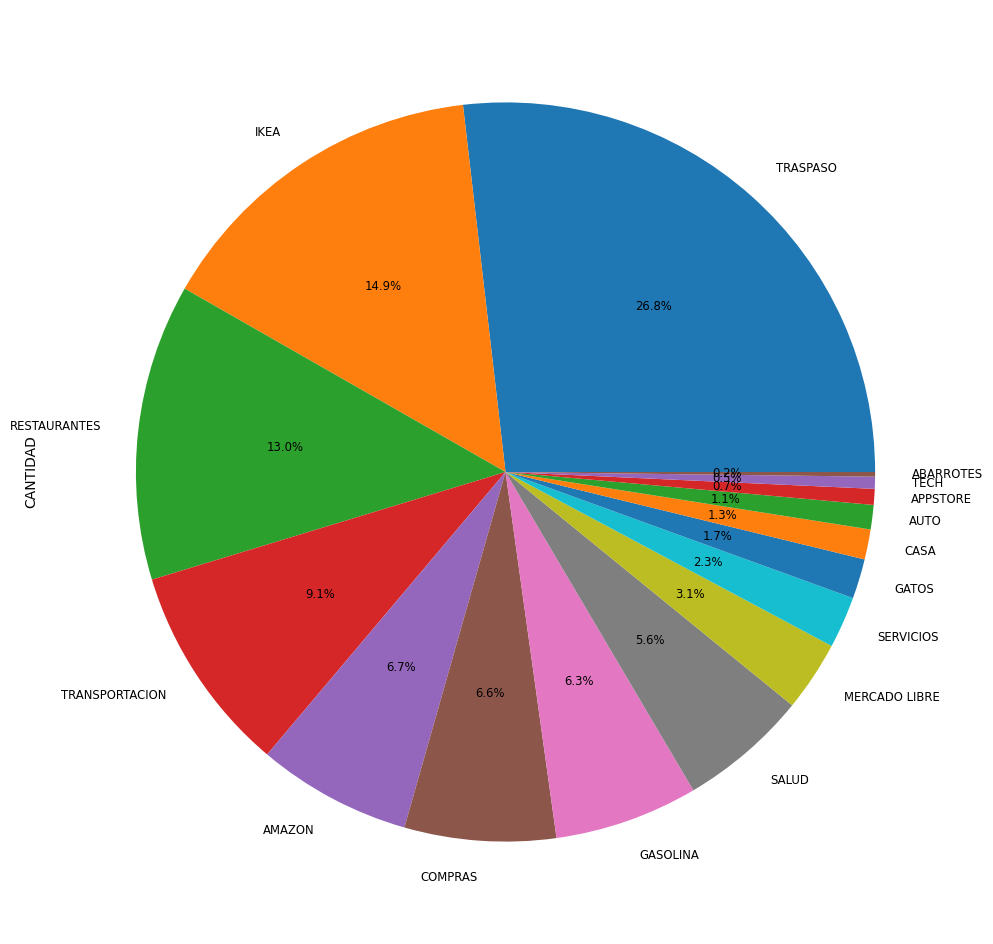

In [34]:
# @title
to_plot.plot.pie(y='CANTIDAD', figsize=(12, 12), autopct='%1.1f%%', labeldistance=1.1, textprops={'size': 'smaller'})

# 9. Lista de gastos por rubro de mayor a menor

In [ ]:
# @title
gastos.groupby(['RUBRO'])['CANTIDAD'].sum().sort_values(ascending=False)

# 10. Si ves que hay demasiados gastos etiquetados como OTROS, el modelo podría requerir más entrenamiento. Puedes reportarlo en el repo de github para mejorarlo.

In [ ]:
# @title
gastos.loc[gastos['RUBRO'] == 'OTROS'].sort_values(by='CANTIDAD', ascending=False)

# Aquí no deberían aparecer renglones que parezcan cargos. Si aparecen significa que se descartaron y no fueron tomados en cuenta.

Lo esperado son renglones como:

`\x17?{]IVH#\x1dT9\x1cd;eZY\x04\x17~IE{+X\1eh7R1$\x0fl'gq}\x1cwUBMI`

In [ ]:
# @title
[i for i in not_matching if (('/' in i or '-' in i) and '$' in i and 'USD' not in i and 'TOTAL IMPORTES:' not in i and 'Rendimiento' not in i and 'Crédito Disponible' not in i and 'Límite de Crédito' not in i and 'Pagos' not in i and 'Ponemos a su dispo' not in i)]

# FINALMENTE AQUÍ PUEDES DESCARGAR LA INFO EN FORMATO CSV PARA QUE LA UTILICES COMO QUIERAS

In [ ]:
gastos.to_csv('gastos.csv')
devoluciones.to_csv('devoluciones.csv')
mensualidades.to_csv('mensualidades.csv')
meses_sin_intereses.to_csv('meses_sin_intereses.csv')
pago_tarjeta.to_csv('pago_tarjeta.csv')